In [5180]:
from sympy import init_session
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import scipy.integrate as it
from scipy.signal import savgol_filter


init_session(use_latex = True)

IPython console for SymPy 1.13.2 (Python 3.10.1-64-bit) (ground types: gmpy)

These commands were executed:
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.13.2/



In [5181]:
# Size
a = 1.8 * 0.0254 #m R2
b = 12.1 * 0.0254 #m R3
c = 3.17 * 0.0254 #m R4
d = 13.4 * 0.0254 #m R1
a, b, c, d

In [5182]:
m = 3.44 #kg
l = 24.5 * 0.0254 #length of wiper m
I = 1/12 * m * l**2 + m * (l/2 * sqrt(2))**2 + 1/3 * m * l**2#moment of inertia about com kgm^2
mu_k = 0.3  # coefficient of kinetic friction
g = 9.81  # gravity (m/s^2)
theta = 25 #degs
n = 3 # order of polynomial filtering 
b = 51 # window size for filter need to be odd number
I

/Users/dylanqiu/opt/anaconda3/lib/python3.10/site-packages/IPython/core/displayhook.py:281: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


In [5183]:
#Parameters
motor_torque = 30 #NM 
df = pd.read_csv("4bardata.txt", sep='\t' , header = None, names = ["time [s]", "theta_2 [rad]", "theta_3 [rad]", "theta_4 [rad]", "theta_2 [°]","theta_3 [°]","theta_4 [°]","omega_2 [rad/s]", "omega_43 [rad/s]","omega_4 [rad/s]","alpha_2 [rad/s^2]","alpha_3 [rad/s^2]","alpha_4 [rad/s^2]"])
#df.head(20)
#print(df.shape[0])


In [5184]:
#Torque Calculations

tau_out = []
err = 15 # to eliminate spikes and use small angle approximation
for i in range(df.shape[0]):
    theta_a = 180.0 - df["theta_2 [°]"][i] + df["theta_3 [°]"][i] # inner angle between link a and b
    theta_b = df["theta_4 [°]"][i]- df["theta_3 [°]"][i] # inner angle between link b and c
    if abs(theta_a) > err and abs(theta_a) < (180-err):
        temp1 = motor_torque * ((c * np.sin(np.deg2rad(theta_b)))/ (a * np.sin(np.deg2rad(theta_a))))
        tau_out.append(temp1)
    elif abs(theta_b) < err and abs(theta_a) > (180-err):
        temp2 = motor_torque * (c * theta_b)/ (a * theta_a)
        tau_out.append(temp2)
    else: 
        temp3 = motor_torque * (c* np.sin(np.deg2rad(theta_b)))/ (a* theta_a)
        tau_out.append(temp3)

filter_tau_out = savgol_filter(tau_out, b, n)
df["Input_Torque [nm]"] = filter_tau_out
print(df["Input_Torque [nm]"].to_string())

0      -5.416192
1       5.200872
2      14.960389
3      23.890172
4      32.018032
5      39.371781
6      45.979230
7      51.868191
8      57.066475
9      61.601894
10     65.502259
11     68.795382
12     71.509074
13     73.671146
14     75.309411
15     76.451680
16     77.125765
17     77.359476
18     77.180626
19     76.617025
20     75.696486
21     74.446820
22     72.895838
23     71.071353
24     69.001175
25     66.713116
26     65.053766
27     62.842773
28     62.240967
29     60.468351
30     57.642442
31     53.841570
32     49.122335
33     43.528378
34     43.134111
35     41.806649
36     39.835690
37     37.378249
38     34.532234
39     31.365814
40     27.930837
41     24.269587
42     20.418444
43     16.409985
44     12.274258
45      8.039569
46      3.732998
47     -0.619255
48     -4.991634
49     -9.359058
50    -13.696786
51    -17.980316
52    -22.185286
53    -26.287388
54    -30.262258
55    -34.085356
56    -37.731809
57    -41.176193
58    -44.3922

In [5185]:
# Equations of Motion
acceleration_t = []
force_spring = []
alpha_w = []
F_n = []
F_friction = []

for i in range(df.shape[0]):
    temp7 = (df["Input_Torque [nm]"][i] )/ I  #alpha
    alpha_w.append(temp7)
    
    temp8 = l * alpha_w[i] #use a = r*alpha to find tangential acceleration
    acceleration_t.append(temp8)
    
    temp9 = (df["Input_Torque [nm]"][i])/l + m * acceleration_t[i] #friction
    F_friction.append(temp8)

    temp10 = F_friction[i] / mu_k #Normal force
    F_n.append(temp10)
    
    temp11 = F_n[i] - m * g * np.cos(np.radians(theta)) #Spring Force
    force_spring.append(temp11)
    
df["F_normal [N]"] = F_n
df["Friction [N]"] = F_friction
df["acc_tan [m/s^2]"] = acceleration_t
df["alpha_w [rad/s^2]"] = alpha_w
df["F_spring [N]"]= force_spring
df.head()

,time [s],theta_2 [rad],theta_3 [rad],theta_4 [rad],theta_2 [°],theta_3 [°],theta_4 [°],omega_2 [rad/s],omega_43 [rad/s],omega_4 [rad/s],alpha_2 [rad/s^2],alpha_3 [rad/s^2],alpha_4 [rad/s^2],Input_Torque [nm],F_normal [N],Friction [N],acc_tan [m/s^2],alpha_w [rad/s^2],F_spring [N]
0,0.00,0.0000,0.265046,1.555820,0.000000,15.186043,89.141940,6.81,-1.036432,-1.036432,0.0,0.121798,29.960644,-5.416192,-9.20032347076383,-2.76009704122915,-2.76009704122915,-4.43531583035377,-39.7849485752174
1,0.01,0.0000,0.265046,1.555820,0.000000,15.186043,89.141940,6.81,-1.036432,-1.036432,0.0,0.121798,29.960644,5.200872,8.83456552751027,2.65036965825308,2.65036965825308,4.25899029126319,-21.7500595769433
2,0.02,0.0681,0.254700,1.546965,3.901843,14.593232,88.634560,6.81,-1.031730,-0.733699,0.0,0.805461,30.537016,14.960389,25.4127668687374,7.62383006062122,7.62383006062122,12.2510526444178,-5.17185823571621
3,0.03,0.1362,0.244433,1.541161,7.803685,14.004996,88.302003,6.81,-1.020598,-0.426671,0.0,1.406589,30.819922,23.890172,40.5815231511711,12.1744569453513,12.1744569453513,19.5636460635567,9.99689804671752
4,0.04,0.2043,0.234307,1.538436,11.705528,13.424778,88.145894,6.81,-1.003890,-0.118261,0.0,1.920327,30.815159,32.018032,54.3880769730650,16.3164230919195,16.3164230919195,26.2195453831263,23.8034518686114


In [5186]:
#Use trapezoidal rule to find v by integration
dt = 0.01
v_tan = it.cumulative_trapezoid(y = df["acc_tan [m/s^2]"], x = df["time [s]"], dx = dt, initial = 0)
#v_nor = it.cumulative_trapezoid(y = df["acc_nor [m/s^2]"], x = df["time [s]"], dx = dt, initial = 0)
df["vel_tan [m/s]"] = v_tan
#df["vel_nor [m/s]"] = v_nor


In [5187]:
#Use trapezoidal rule to find position by integration
dt = 0.01
tan = it.cumulative_trapezoid(y = df["vel_tan [m/s]"], x = df["time [s]"],dx = dt, initial = 0)
#nor = it.cumulative_trapezoid(y = df["vel_nor [m/s]"], x = df["time [s]"],dx = dt, initial = 0)
df["pos_tan [m]"] = tan
#df["pos_nor [m]"] = nor

In [5188]:
df.head()


,time [s],theta_2 [rad],theta_3 [rad],theta_4 [rad],theta_2 [°],theta_3 [°],theta_4 [°],omega_2 [rad/s],omega_43 [rad/s],omega_4 [rad/s],...,alpha_3 [rad/s^2],alpha_4 [rad/s^2],Input_Torque [nm],F_normal [N],Friction [N],acc_tan [m/s^2],alpha_w [rad/s^2],F_spring [N],vel_tan [m/s],pos_tan [m]
0,0.00,0.0000,0.265046,1.555820,0.000000,15.186043,89.141940,6.81,-1.036432,-1.036432,...,0.121798,29.960644,-5.416192,-9.20032347076383,-2.76009704122915,-2.76009704122915,-4.43531583035377,-39.7849485752174,0,0
1,0.01,0.0000,0.265046,1.555820,0.000000,15.186043,89.141940,6.81,-1.036432,-1.036432,...,0.121798,29.960644,5.200872,8.83456552751027,2.65036965825308,2.65036965825308,4.25899029126319,-21.7500595769433,-0.000548636914880336,-2.74318457440168e-6
2,0.02,0.0681,0.254700,1.546965,3.901843,14.593232,88.634560,6.81,-1.031730,-0.733699,...,0.805461,30.537016,14.960389,25.4127668687374,7.62383006062122,7.62383006062122,12.2510526444178,-5.17185823571621,0.0508223616794912,0.000248625439248652
3,0.03,0.1362,0.244433,1.541161,7.803685,14.004996,88.302003,6.81,-1.020598,-0.426671,...,1.406589,30.819922,23.890172,40.5815231511711,12.1744569453513,12.1744569453513,19.5636460635567,9.99689804671752,0.149813796709354,0.00125180623119288
4,0.04,0.2043,0.234307,1.538436,11.705528,13.424778,88.145894,6.81,-1.003890,-0.118261,...,1.920327,30.815159,32.018032,54.3880769730650,16.3164230919195,16.3164230919195,26.2195453831263,23.8034518686114,0.292268196895708,0.00346221619921819


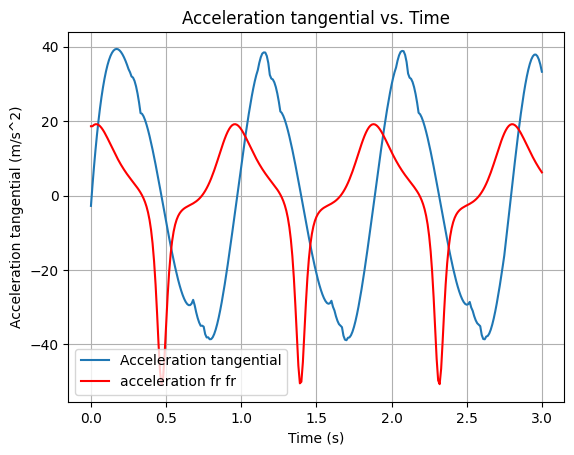

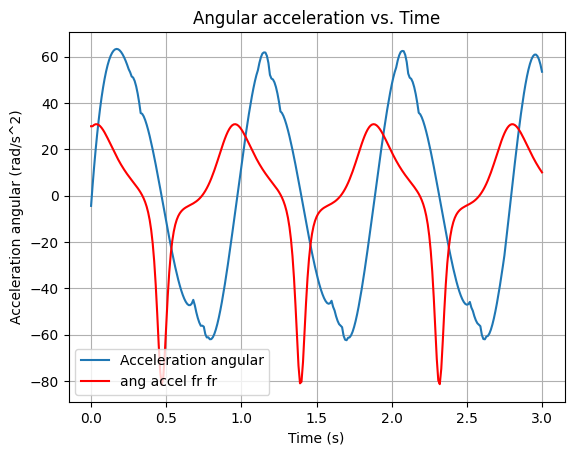

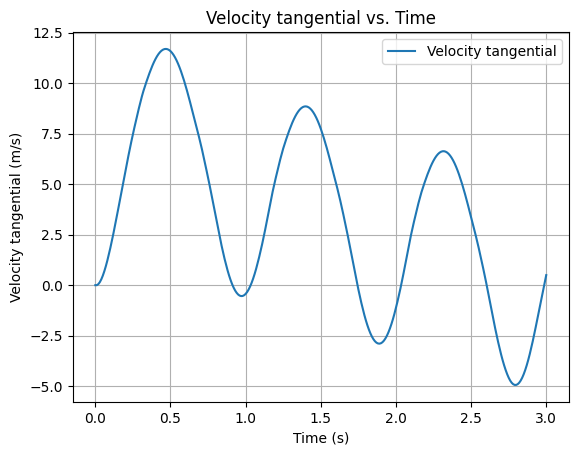

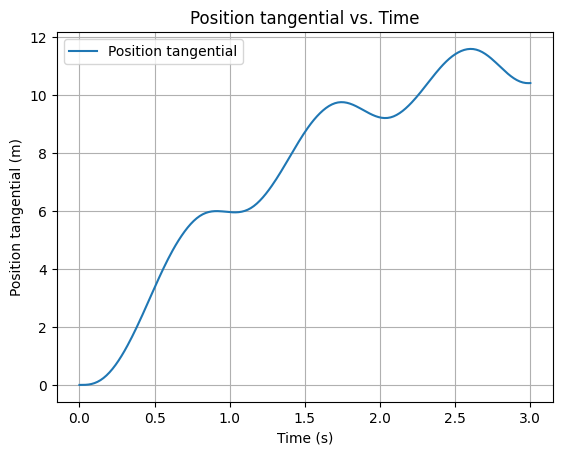

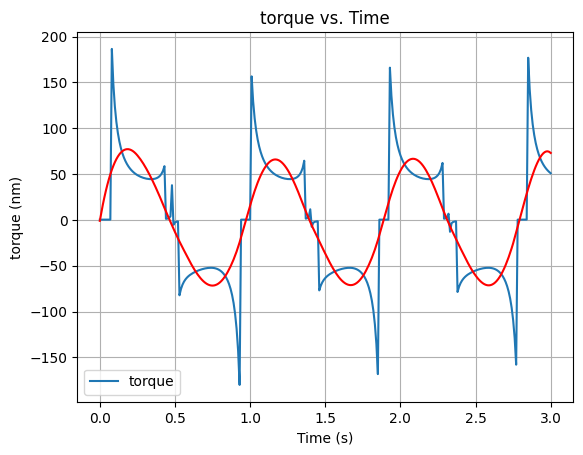

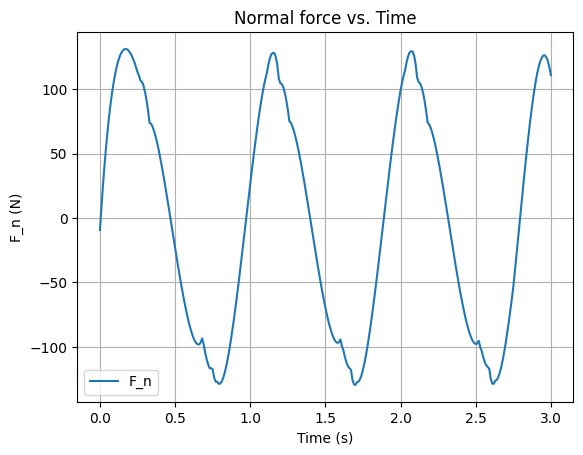

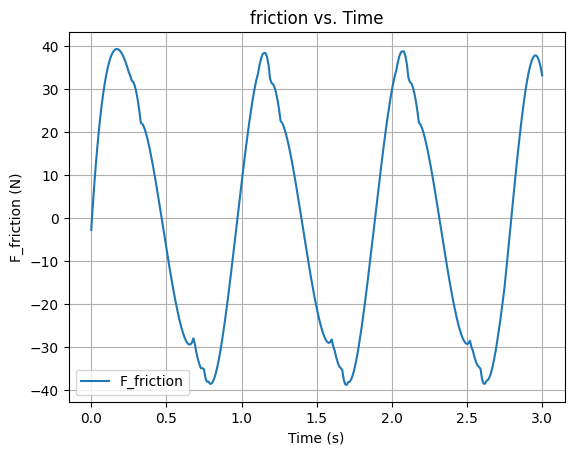

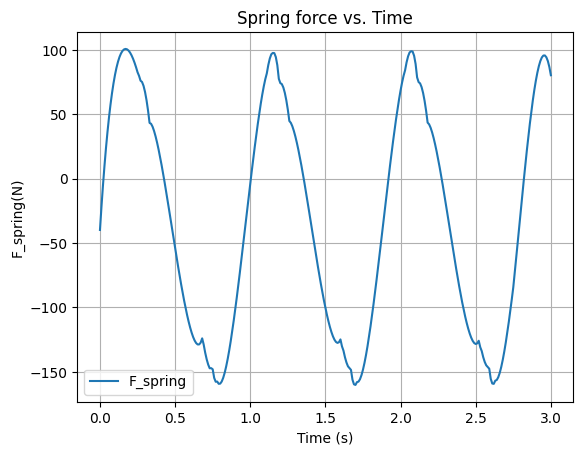

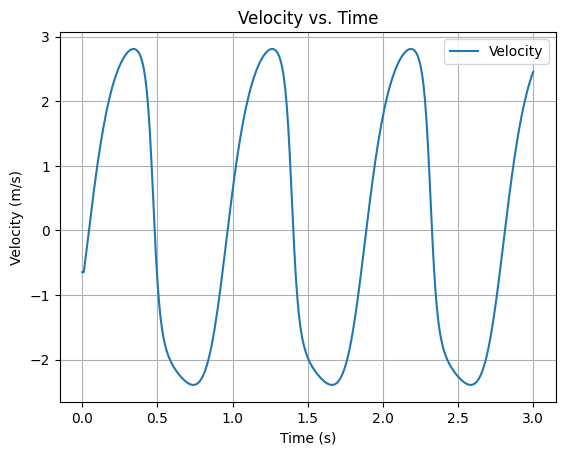

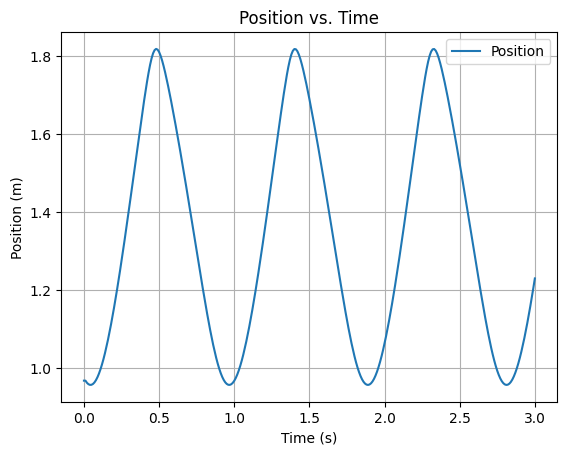

In [5189]:
# Plotting the graphs

plt.plot(df["time [s]"], df["acc_tan [m/s^2]"], label='Acceleration tangential')
plt.plot(df["time [s]"], l * df["alpha_4 [rad/s^2]"], label='acceleration fr fr', color = 'red')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration tangential (m/s^2)')
plt.title('Acceleration tangential vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], df["alpha_w [rad/s^2]"], label='Acceleration angular')
plt.plot(df["time [s]"], df["alpha_4 [rad/s^2]"], label='ang accel fr fr ', color = 'red')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration angular (rad/s^2)')
plt.title('Angular acceleration vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], df["vel_tan [m/s]"] , label='Velocity tangential')
plt.xlabel('Time (s)')
plt.ylabel('Velocity tangential (m/s)')
plt.title('Velocity tangential vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], df["pos_tan [m]"] , label='Position tangential')
plt.xlabel('Time (s)')
plt.ylabel('Position tangential (m)')
plt.title('Position tangential vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], tau_out, label='torque')
plt.xlabel('Time (s)')
plt.ylabel('torque (nm)')
plt.title('torque vs. Time')
plt.legend()
plt.grid()
yhat = savgol_filter(df["Input_Torque [nm]"], b, n) # window size b, polynomial order n
plt.plot(df["time [s]"],yhat, color = 'red')
plt.show()


plt.plot(df["time [s]"], df["F_normal [N]"], label='F_n')
plt.xlabel('Time (s)')
plt.ylabel('F_n (N)')
plt.title('Normal force vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], df["Friction [N]"], label='F_friction')
plt.xlabel('Time (s)')
plt.ylabel('F_friction (N)')
plt.title('friction vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], df["F_spring [N]"], label='F_spring')
plt.xlabel('Time (s)')
plt.ylabel('F_spring(N)')
plt.title('Spring force vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], l * df["omega_4 [rad/s]"], label='Velocity')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], l * df["theta_4 [rad]"], label='Position')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.title('Position vs. Time')
plt.legend()
plt.grid()
plt.show()